# Does GPT-3 appreciate jokes?

*Sean Trott*

**Goal**: Does GPT-3 successfully distinguish jokes from non-jokes? How funny does it find jokes?

## Setup 

### Set up API

In [1]:
import openai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [2]:
import statsmodels.formula.api as smf

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [4]:
## Read in key
with open('gpt_key', 'r') as f:
    lines = f.read().split("\n")
org = lines[0]
api_key = lines[1]
openai.organization = org # org
openai.api_key = api_key # api_key

### Load data

In [5]:
df = pd.read_csv("data/raw/coulson_stimuli.csv")

In [6]:
df.head(5)

,Condition,Exp Code,Sentence,Answer,Correct,First Five Words,Group Number,Same/Different
0,J,1017,A committee keeps minutes and takes hours.,Committees are very efficient.,no,a committee keeps minutes and,1,Different
1,S,3017,A committee keeps minutes and takes votes.,Committees keep records and make decisions.,yes,a committee keeps minutes and,1,Different
2,S,4013,A device for finding furniture in the dark is ...,The candle gives off light.,yes,a device for finding furniture,2,Same
3,J,2013,A device for finding furniture in the dark is ...,People run into furniture when it's dark.,yes,a device for finding furniture,2,Same
4,E,6056,A good source of vitamin A is orange vegetable...,Carrots contain vitamin A.,yes,a good source of vitamin,3,E


### Setup helper functions

In [10]:
import backoff  # for exponential backoff

@backoff.on_exception(backoff.expo, openai.error.RateLimitError)
def get_response(prompt, model, tokens = 0):
    response = openai.Completion.create(
        model=model,
        prompt=prompt,
        temperature=0,
        max_tokens=tokens, ### 0
        logprobs = 0,
        top_p=1,
        echo = True
    )
    
    return response

## Pt. 1: Joke classification

In this section, we ask whether GPT-3 successfully distinguishes jokes from non-jokes by comparing `p(yes)` vs. `p(no)` to the question: "Is this statement a joke?" for jokes and non-jokes.

In [28]:
INSTRUCTIONS_CLASSIFICATION = "You will be shown a series of statements. For each, your task is to determine whether or not the statement is a joke."
print(INSTRUCTIONS_CLASSIFICATION)

You will be shown a series of statements. For each, your task is to determine whether or not the statement is a joke.


### Helper

In [29]:
def format_prompt(sentence, prompt, response):
    prompt = "{p}\n\nIs this statement a joke?\n\n{x}\n\nAnswer: {y}".format(
        p = prompt, x = sentence, y = response)
    return prompt

### Main

In [30]:
models = ["text-davinci-002"]

In [33]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    answer = row['Answer']
    
    yes_prompt = format_prompt(sentence, prompt = INSTRUCTIONS_CLASSIFICATION, 
                               response = "Yes")
    no_prompt = format_prompt(sentence, prompt = INSTRUCTIONS_CLASSIFICATION, 
                              response = "No")
    
    for model in models:

        ## Get responses
        yes_response = get_response(yes_prompt, model = model)
        no_response = get_response(no_prompt, model = model)
        
        
        ## Extract tokenized representations: YES
        yes_tokens = yes_response.to_dict()['choices'][0]['logprobs']['tokens']
        yes_identified_token = yes_tokens[-1]
        if yes_identified_token != " Yes":
            print(yes_identified_token) 
            
        ## Extract tokenized representations: NO
        no_tokens = no_response.to_dict()['choices'][0]['logprobs']['tokens']
        no_identified_token = no_tokens[-1]
        if no_identified_token != " No":
            print(no_identified_token)
        
        
        ## Get logprobs
        lp_yes = yes_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
        lp_no = no_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
            
        
        results.append({
            'model': model,
            'sentence': sentence,
            'answer': answer,
            'condition': row['Condition'],
            'correct': row['Correct'],
            'yes_lp': lp_yes, 
            'no_lp': lp_no
        })
            
        

100%|█████████████████████████████████████████| 400/400 [02:48<00:00,  2.37it/s]


In [35]:
df_results = pd.DataFrame(results)

In [37]:
df_results.head(5)

,model,sentence,answer,shots,condition,correct,yes_lp,no_lp
0,text-davinci-002,A committee keeps minutes and takes hours.,Committees are very efficient.,0,J,no,-1.743327,-1.063580
1,text-davinci-002,A committee keeps minutes and takes votes.,Committees keep records and make decisions.,0,S,yes,-7.378091,-0.278357
2,text-davinci-002,A device for finding furniture in the dark is ...,The candle gives off light.,0,S,yes,-3.008099,-0.435998
3,text-davinci-002,A device for finding furniture in the dark is ...,People run into furniture when it's dark.,0,J,yes,-3.017649,-0.359194
4,text-davinci-002,A good source of vitamin A is orange vegetable...,Carrots contain vitamin A.,0,E,yes,-10.157684,-0.346942


In [41]:
df_results['lp_ratio'] = df_results['yes_lp'] - df_results['no_lp']
df_results['is_joke'] = df_results['condition'] == "J"

<AxesSubplot:xlabel='is_joke', ylabel='yes_lp'>

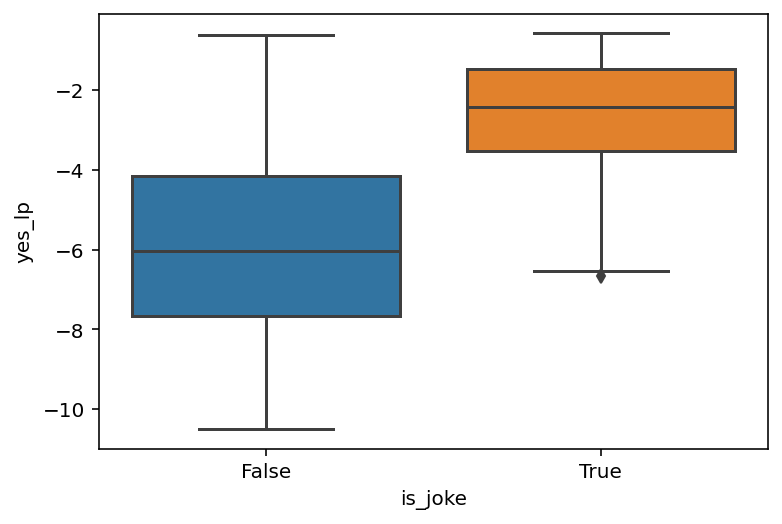

In [42]:
sns.boxplot(data = df_results, x = "is_joke", y = "yes_lp")

In [43]:
df_results.to_csv("data/processed/llm_classification.csv", index = False)

## Pt. 2: Joke appreciation

Response options:
- Not Funny
- Somewhat Funny
- Moderately Funny
- Funny
- Very Funny

**TODO**: Scale of 1-5.

In [44]:
INSTRUCTIONS_APPRECIATION = "You will be shown a series of statements. For each, your task is to indicate how funny you find the statement to be.  "
print(INSTRUCTIONS_APPRECIATION)

You will be shown a series of statements. For each, your task is to indicate how funny you find the statement to be.  


### Helper

In [68]:
import math

In [45]:
def format_prompt(sentence, prompt, response):
    prompt = "{p}\n\nOn a scale of 1 to 5, how funny do you think this statement is? The scale is 1 (Not Funny), 2 (Somewhat Funny), 3 (Moderately Funny), 4 (Funny), and Very Funny (5).\n\n{x}\n\nAnswer: {y}".format(
        p = prompt, x = sentence, y = response)
    return prompt

### Main

In [99]:
models = ["text-davinci-002"]

In [100]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    answer = row['Answer']
    
    responses = {}
    for r in range(1, 6):
        responses[r] = format_prompt(sentence, prompt = INSTRUCTIONS_APPRECIATION, 
                               response = r)
    
    for model in models:

        ## Get responses
        r_to_lp = {}
        for r, prompt in responses.items():
            gpt_response = get_response(prompt, model = model)
            token = gpt_response.to_dict()['choices'][0]['logprobs']['tokens'][-1]
            if token.strip() != str(r):
                print(token)
                print(r)
            lp_token = gpt_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
            r_to_lp[r] = lp_token
            
        max_key = max(r_to_lp, key=r_to_lp.get)
        max_value = r_to_lp[max_key]
        
        probabilities = [math.exp(value) for value in r_to_lp.values()]
        
        entropy = -sum([p * math.log(p) for p in probabilities])

        
        ### TODO:
        #### Get best-p response
        #### Get p of best-p response
        #### Get entropy of distribution
        
        results.append({
            'model': model,
            'sentence': sentence,
            'answer': answer,
            'condition': row['Condition'],
            'best_response': max_key,
            'best_response_lp': max_value,
            'entropy': entropy
        })
            
        

100%|█████████████████████████████████████████| 400/400 [07:14<00:00,  1.09s/it]


In [101]:
df_results = pd.DataFrame(results)

In [102]:
df_results['is_joke'] = df_results['condition'] == "J"
df_results.head(5)

,model,sentence,answer,condition,best_response,best_response_lp,entropy,is_joke
0,text-davinci-002,A committee keeps minutes and takes hours.,Committees are very efficient.,J,3,-0.615764,0.694764,True
1,text-davinci-002,A committee keeps minutes and takes votes.,Committees keep records and make decisions.,S,1,-0.649445,0.669604,False
2,text-davinci-002,A device for finding furniture in the dark is ...,The candle gives off light.,S,3,-0.613520,0.640976,False
3,text-davinci-002,A device for finding furniture in the dark is ...,People run into furniture when it's dark.,J,3,-0.393362,0.704891,True
4,text-davinci-002,A good source of vitamin A is orange vegetable...,Carrots contain vitamin A.,E,1,-0.100589,0.098394,False


In [103]:
df_results.to_csv("data/processed/llm_appreciation.csv", index = False)

In [115]:
df_results.sort_values("best_response", ascending = False)[['sentence', 'best_response', 'is_joke']].head(10)['sentence'].values

array(["Charged with statutory rape, he told the judge he didn't know she was a statue.",
       'To get something done, a committee should consist of no more than three people, two of whom are dead.',
       'The new tax forms are more realistic-- where your wife signs, it says: accomplice.',
       'A committee keeps minutes and takes hours.',
       'She told him he looked like a million, and she meant every syllable.',
       'Some husbands are good providers, but only if you count children.',
       'Some babies are born to rule, while others are weak.',
       'Some babies are born to rule, while others are male.',
       "She's happy because she finally has a boyfriend who gets along with her fiance.",
       'She went on a fourteen day diet, but she only lost two weeks.'],
      dtype=object)

<AxesSubplot:xlabel='is_joke', ylabel='best_response'>

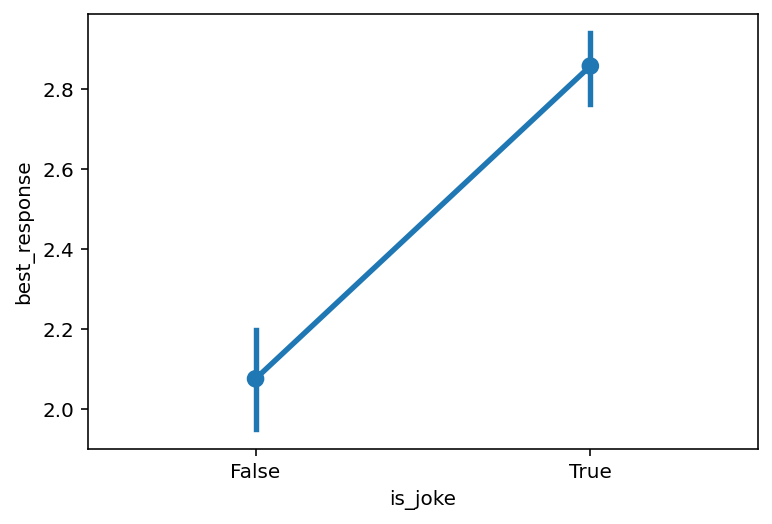

In [104]:
sns.pointplot(data = df_results, x = "is_joke", y = "best_response")

<AxesSubplot:xlabel='is_joke', ylabel='entropy'>

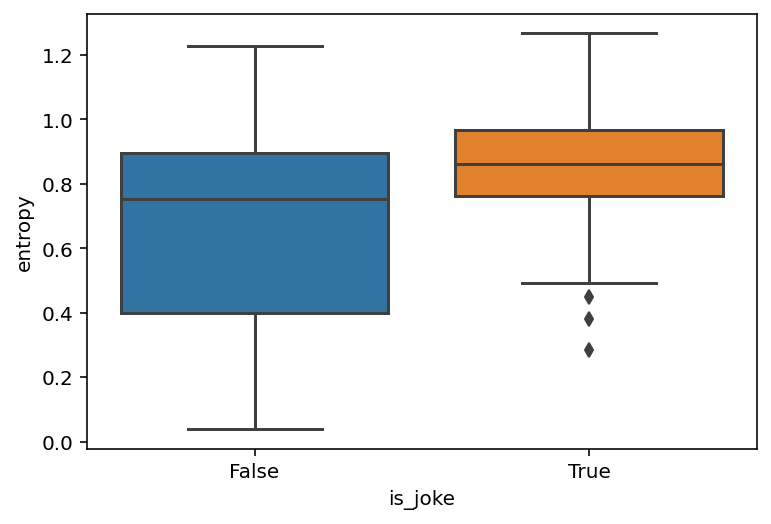

In [105]:
sns.boxplot(data = df_results, x = "is_joke", y = "entropy")

<AxesSubplot:xlabel='best_response', ylabel='Count'>

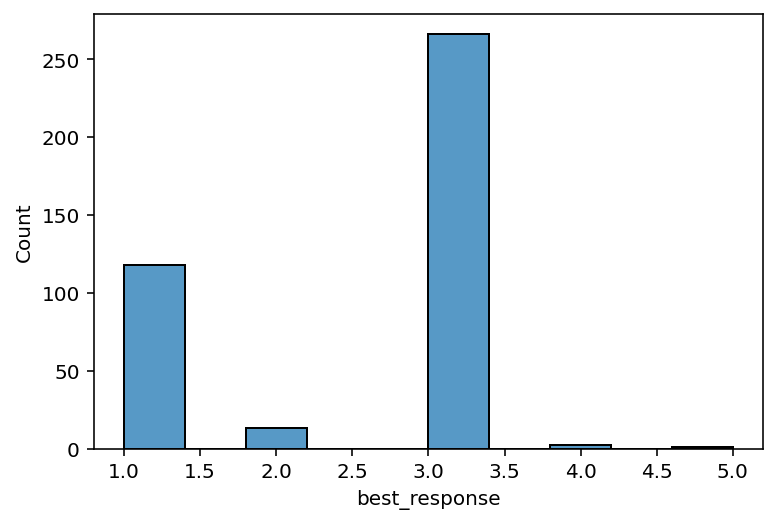

In [106]:
sns.histplot(data = df_results, x = "best_response")

<AxesSubplot:xlabel='entropy', ylabel='Count'>

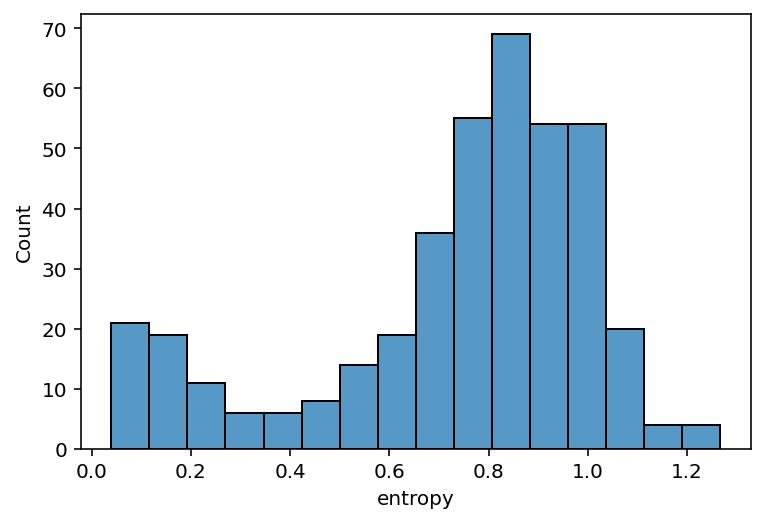

In [107]:
sns.histplot(data = df_results, x = "entropy")